In [52]:
# All credit to the code I've copied from
# https://github.com/wukevin/proteinclip/blob/main/proteinclip/esm_wrapper.py
import esm
import torch.nn as nn
import torch
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import umap
import matplotlib.pyplot as plt

ESM_CALLABLES = {
    48: esm.pretrained.esm2_t48_15B_UR50D,
    36: esm.pretrained.esm2_t36_3B_UR50D,
    33: esm.pretrained.esm2_t33_650M_UR50D,
    30: esm.pretrained.esm2_t30_150M_UR50D,
    12: esm.pretrained.esm2_t12_35M_UR50D,
    6: esm.pretrained.esm2_t6_8M_UR50D,
}

# https://www.rcsb.org/structure/4O75
protein = "rcsb_pdb_4O75.fasta"

In [3]:
def get_model(model_size: int) -> tuple[nn.Module, esm.Alphabet]:
    """Return model and alphabet for a given model size."""
    model, alphabet = ESM_CALLABLES[model_size]()
    model.eval()
    return model, alphabet

In [19]:
def read_fasta(filename):
	fa = SeqIO.parse(filename, "fasta")
	sequences = []
	ids = []
	for i in fa:
		ids.append(i.id)
		sequences.append(str(i.seq))
	return list(zip(ids,sequences ))

In [76]:
def embed(sequence, model, alphabet, embed_layer=5):
    batch_converter = alphabet.get_batch_converter()

    _,_, tokens = batch_converter(
        [("", sequence)]
    )
    with torch.no_grad():
        results = model(
            tokens, repr_layers=[embed_layer], return_contacts=False
        )
    token_representations = results["representations"][embed_layer]
    rep = token_representations[0, 1 : 1 + len(sequence)].cpu().numpy()
    rep = rep.mean(0)

    return rep

In [62]:
from Bio.SeqUtils import seq1
from io import StringIO
from Bio.PDB import PDBParser
import os

VENOME = "/Users/donnybertucci/datasets/venome"

def amino_acids(structure, one_letter_code=True):
	return "".join([
		seq1(residue.resname) if one_letter_code else residue.resname
		for residue in structure.get_residues()
	])

def read_fasta_from_pdbs(path):
	if not os.path.exists(path):
		raise Exception(path + " does not exist")
	
	files = os.listdir(path)
	sequences = []
	ids = []
	for f in files:
		parser = PDBParser()
		structure = parser.get_structure(
				id=None, file=os.path.join(path, f)
		)
		ids.append(f)
		sequences.append(amino_acids(structure))
	
	return list(zip(ids, sequences))

seqs = read_fasta_from_pdbs(VENOME)
len(seqs)

436

In [77]:
out = []
layer = 30
m, a = get_model(layer)
for i, s in tqdm(seqs):
	out.append(embed(s, m, a, layer))

100%|██████████| 436/436 [06:41<00:00,  1.08it/s]


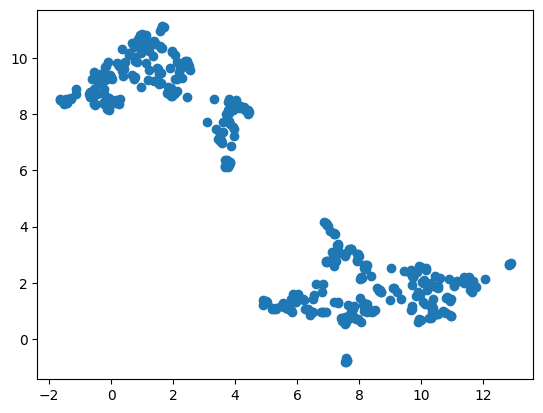

In [78]:
project = umap.UMAP()
out2D = project.fit_transform(out)
plt.scatter(out2D[:, 0], out2D[:, 1])

In [79]:
import pandas as pd

In [82]:
pd.DataFrame({"name":  [i for i,s in seqs], "embed-30": out }).to_parquet("embed30.parquet")

,name,embed-30
0,Lh14_comp137_c2_seq1.pdb,"[-0.0683364, -0.09229992, -0.06664363, -0.1422..."
1,Lh14_comp797_c0_seq3.pdb,"[-0.072703, -0.053945504, 0.091969036, 0.15721..."
2,Gh_comp244_c0_seq1.pdb,"[0.060252294, -0.11117418, 0.025219534, -0.055..."
3,Lh14_comp1630_c0_seq5.pdb,"[-0.07718672, 0.033781517, -0.02802218, -0.021..."
4,Gh_comp714_c0_seq1.pdb,"[-0.02680155, -0.065228485, -0.08670912, -0.03..."
...,...,...
431,Lh14_comp131_c0_seq1.pdb,"[0.017292315, -0.117223606, -0.060315054, 0.02..."
432,Lh14_comp2613_c1_seq2.pdb,"[-0.14403377, 0.06453869, 0.026057027, -0.0275..."
433,Lb17_comp433_c0_seq1.pdb,"[-0.11523464, 0.09561256, 0.03285806, -0.10856..."
434,Gh_comp6627_c0_seq1.pdb,"[-0.11080586, 0.035449702, -0.07572947, -0.152..."
